In [517]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import tensorflow as tf
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import plotly.express as px
import statistics
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import kaleido
sns.set(rc={'figure.figsize':(15,5)})

In [438]:
normal = pd.read_csv('normal.csv')
ssp2_10_40 = pd.read_csv('ssp2_10_41.csv')
ssp2_41_70 = pd.read_csv('ssp2_41_70.csv')
ssp5_10_40 = pd.read_csv('ssp5_11_40.csv')
ssp5_41_70 = pd.read_csv('ssp5_41_70.csv')
dataframes = [normal, ssp2_10_40, ssp2_41_70, ssp5_10_40, ssp5_41_70]

# Pre-processing

In [540]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_dataframes = []
for df in dataframes:
  data = pd.DataFrame(scaler.fit_transform(df))
  data.columns = df.columns
  scaled_dataframes.append(data)

In [541]:
def get_x_y(df):
    wind_x = df[df.capacity_m.notna()].iloc[:,13:].dropna()
    wind_y = df.loc[wind_x.index,'capacity_m']
    solar_x = df[df.pv_capacit.notna()].iloc[:,13:].dropna()
    solar_y = df.loc[solar_x.index,'pv_capacit']
    wind_df = df.iloc[wind_x.index,:]
    solar_df = df.iloc[solar_x.index,:]
    return wind_x, wind_y, solar_x, solar_y, wind_df, solar_df

In [542]:
def prep_data(df, wind_or_solar):
  wind_x, wind_y, solar_x, solar_y, wind_df, solar_df = get_x_y(df)
  if wind_or_solar=='solar':
    X_train, X_test, y_train, y_test = train_test_split(solar_x,solar_y,random_state=42)
  else: 
    X_train, X_test, y_train, y_test = train_test_split(wind_x,wind_y,random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state=42) 
  return X_train, X_test, y_train, y_test, X_val, y_val



# Finding the Most Accurate DNN Model for Solar Normal data

#### Data and Function Prep for DNN

In [543]:
X_train, X_test, y_train, y_test, X_val, y_val = prep_data(scaled_dataframes[0], 'solar')
EPOCHS = 100
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

def history_plot(model_history,title,saveas):
    plot = pd.DataFrame(model_history.history).plot(figsize=(15, 5)) 
    plt.grid(True)
    plt.gca()#.set_ylim(0, topylim)
    plt.title(title)
    plt.show()
    fig = plot.get_figure()
    fig.savefig(f"{saveas}_history.png", width=600, height=200)

def to_graph_df(model, wind_or_solar):
    train_predict = pd.DataFrame(model.predict(X_train))#.rename({0:'predicted_train'},axis=1)
    train_predict['predict_type'] = 'train'
    test_predict = pd.DataFrame(model.predict(X_test))#.rename({0:'predicted_test'},axis=1)
    test_predict['predict_type'] = 'test'
    val_predict = pd.DataFrame(model.predict(X_val))#.rename({0:'predicted_validation'},axis=1)
    val_predict['predict_type'] = 'val'
    actual_data = pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_val),pd.DataFrame(y_test)],axis=0)
    train_predict.index = X_train.index
    test_predict.index = X_test.index
    val_predict.index = X_val.index
    predicted_data = pd.concat([train_predict,test_predict,val_predict],axis=0)
    modeldata = predicted_data.merge(actual_data,left_index=True,right_index=True).rename({0:'predicted_y'},axis=1)
    return modeldata
def get_mse_corr(result_df,predict_type,outcome_variable):
  sub_df = result_df[result_df.predict_type==predict_type]
  mse = mean_squared_error(sub_df[outcome_variable], sub_df.predicted_y)
  corr = pearsonr(sub_df[outcome_variable], sub_df.predicted_y)

  return mse, corr

def get_compiled_results(model,history,title,model_name,wind_or_solar,saveas):
  if wind_or_solar == 'solar':
    y_var = 'pv_capacit'
    y_label = 'Predicted PV Capacity Factor '
  else:
    y_var = 'capacity_m'
    y_label = 'Predicted Wind Capacity Factor'
  history_plot(history,title,saveas)
  result = to_graph_df(model,wind_or_solar)

  actual = pd.DataFrame(result[y_var]).rename({y_var:'predicted_y'},axis=1)
  actual['predict_type'] = 'actual_y'

  boxplot_df = pd.concat([result,actual]).rename({'predicted_y':'y_values'},axis=1)
  h = sns.boxplot(data=boxplot_df, x='y_values', y='predict_type')
  h.set(ylabel='Prediction Type or Actual Y Values', xlabel=y_label)
  fig = h.get_figure()
  fig.savefig(f"{saveas}_boxplot.png", width=600, height=200)

  g = sns.lmplot(data=result,x='predicted_y',y=y_var,scatter_kws={'alpha':0.5},
                 col="predict_type", height=3,
                facet_kws=dict(sharex=False, sharey=True),
            )
  g.fig.set_size_inches(15,4)
  g.set(xlabel='Model Predicted Y', ylabel=y_label)
  plt.savefig(f"{saveas}_three_plots.png", width=600, height=200)

  loop_results = ['train','test','val']
  for i,v in enumerate(loop_results):
    error_val, corr = get_mse_corr(result,v,y_var)
    print(f"{model_name} {v} outcome has {round(error_val,5)} MSE and the predicted data has {round(corr[0]*100,2)}& correlation at {corr[1]} p-level with the actual data.")

def get_model_results(model,model_history,wind_or_solar):
  model_results = []
  if wind_or_solar == 'solar':
    y_var = 'pv_capacit'
  else:
    y_var = 'capacity_m'
  loop_results = ['train','test','val']
  result = to_graph_df(model,wind_or_solar)
  for i,v in enumerate(loop_results):
    error_val, corr = get_mse_corr(result,v,y_var)
    model_results.append(error_val)
    model_results.append(round(corr[0]*100,2))
  model_results.append(statistics.variance(model_history.history['loss']))
  model_results.append(statistics.variance(model_history.history['val_loss']))
  model_results.append(round((model_history.history['loss'][-1] - model_history.history['loss'][0])/len(model_history.history['loss']),7))
  model_results.append(round((model_history.history['val_loss'][-1] - model_history.history['val_loss'][0])/len(model_history.history['val_loss']),7))

  columns = ['Train MSE','Train Corr', 'Test MSE','Test Corr','Validation MSE','Validation Corr','Train Loss Variance','Validation Loss Variance','Rate of Change in Train Loss','Rate of Change in Validation Loss']
  result_summary = pd.DataFrame(model_results).T
  result_summary.columns = columns
  return result_summary

## DNN Model 1 - Simple DNN with Early Stopping
 If the loss curve flattens at a high value early, the learning rate is probably low. If the loss curve follows a zigzag pattern, the learning rate is too high.

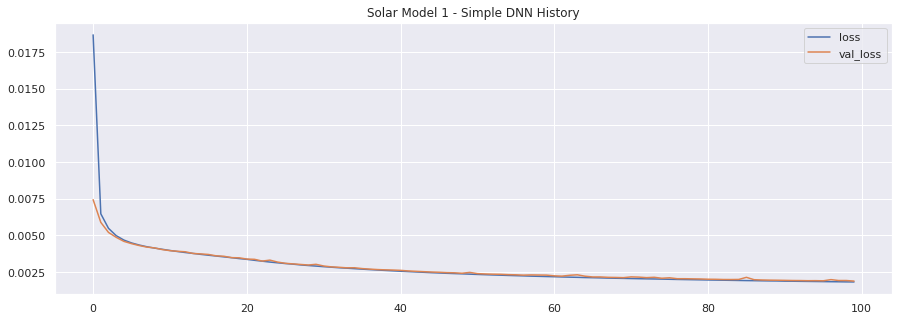

617/617 [==============================] - 1s 1ms/step
SModel1_1 train outcome has 0.00181 MSE and the predicted data has 97.03& correlation at 0.0 p-level with the actual data.
SModel1_1 test outcome has 0.00194 MSE and the predicted data has 96.87& correlation at 0.0 p-level with the actual data.
SModel1_1 val outcome has 0.00187 MSE and the predicted data has 96.93& correlation at 0.0 p-level with the actual data.


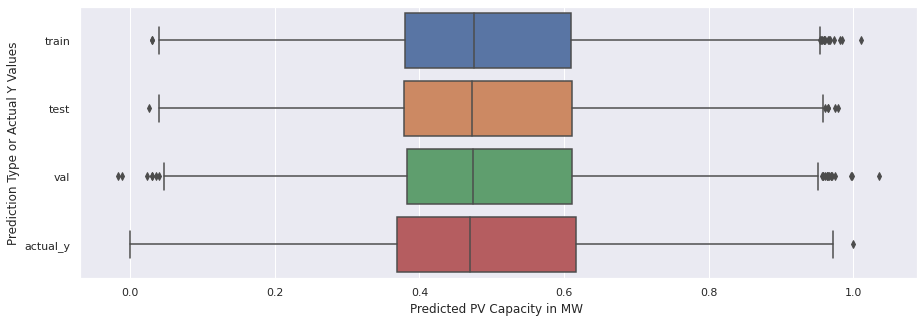

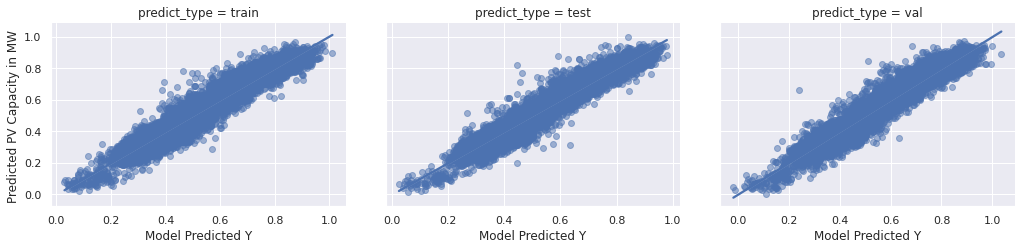

In [544]:
smodel1_1 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
smodel1_1.compile(loss="mean_squared_error", optimizer="sgd")

history1_1 = smodel1_1.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_1,history1_1,'Solar Model 1 - Simple DNN History','SModel1_1','solar','solar_model12')

## DNN Model 2 - Simple DNN with SELU and Early Stopping



In [ ]:
initializer = tf.keras.initializers.LecunNormal()

smodel1_2 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="selu", input_shape=X_train.shape[1:],kernel_initializer=initializer),
         tf.keras.layers.Dense(1)
     ])
smodel1_2.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_2 = smodel1_2.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_2,shistory1_2,'Solar Model 2 - Simple DNN with SELU History','SModel1_2','solar','solar_model22')

## DNN Model 3 - Simple Model with DNN ADAM


In [ ]:
smodel1_3 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(1)
     ])
smodel1_3.compile(loss="mean_squared_error", optimizer="adam")

shistory1_3 = smodel1_1.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_3,shistory1_3,'Solar Model 3 - Simple DNN History with ADAM','SModel1_3','solar','solar_model32')

## DNN Model 4 - Multilayer Model

In [ ]:
smodel1_4 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dense(1)
     ])
smodel1_4.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_4 = smodel1_4.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_4,shistory1_4,'Solar Model 4 = Multilayer DNN History','SModel1_4','solar','solar_model42')

## DNN Model  - Multilayer Model with Batch Normalization

In [ ]:
smodel1_5 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_5.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_5 = smodel1_5.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_5,shistory1_5,'Solar Model 5 - Multilayer DNN with Batch Normalization History ','SModel1_5','solar','solar_model52')

In [340]:
## DNN Model 6 - Multilayer Model with Batch Normalization and Dropout

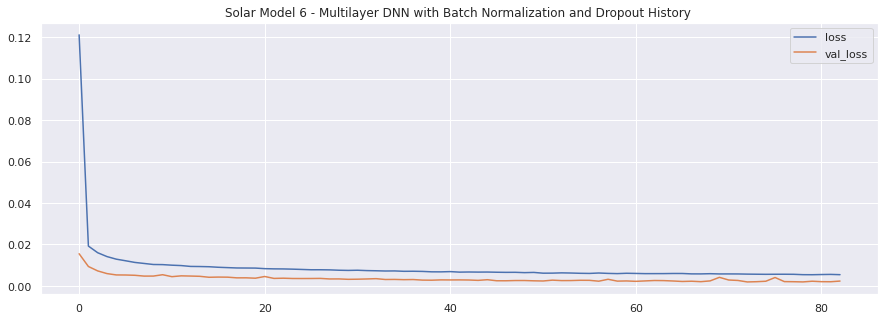

617/617 [==============================] - 3s 4ms/step
SModel1_6 train outcome has 0.00189 MSE and the predicted data has 96.9& correlation at 0.0 p-level with the actual data.
SModel1_6 test outcome has 0.00199 MSE and the predicted data has 96.77& correlation at 0.0 p-level with the actual data.
SModel1_6 val outcome has 0.00191 MSE and the predicted data has 96.85& correlation at 0.0 p-level with the actual data.


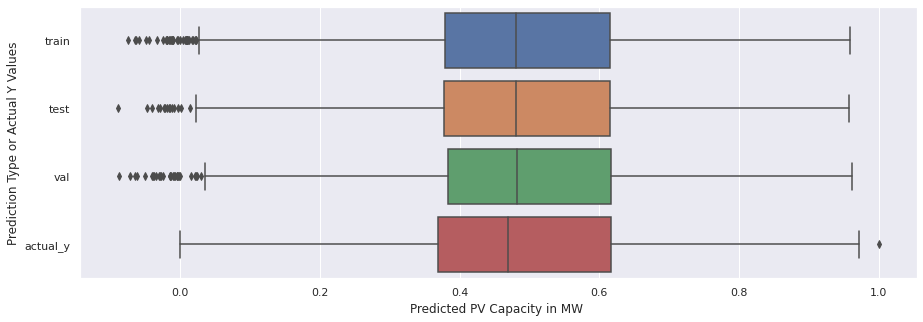

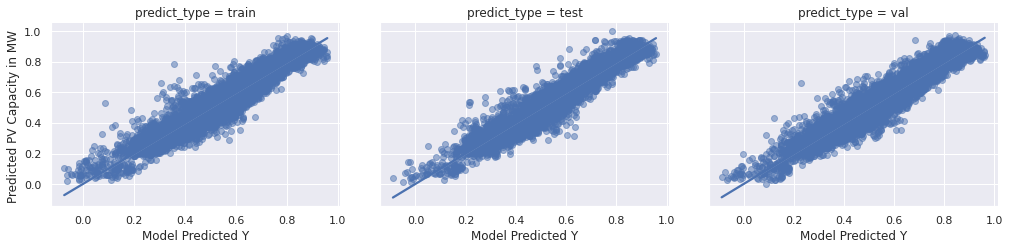

In [341]:
smodel1_6 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_6.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_6 = smodel1_6.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_6,shistory1_6,'Solar Model 6 - Multilayer DNN with Batch Normalization and Dropout History ','SModel1_6','solar','solar_model6')

## DNN Model 7 - Multilayer Model with Batch Normalization and Higher Dropout and Lower LR

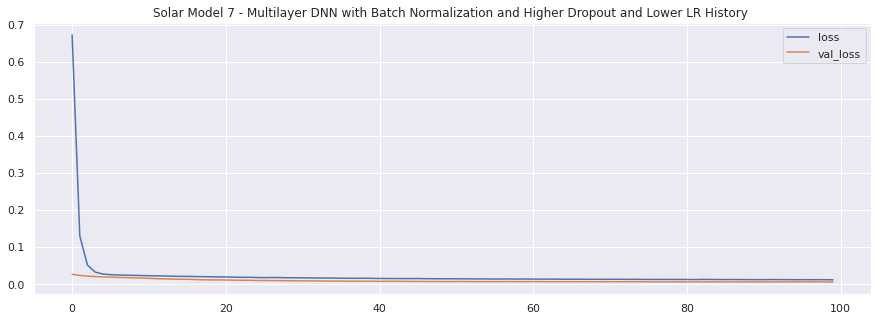

617/617 [==============================] - 3s 5ms/step
SModel1_7 train outcome has 0.00509 MSE and the predicted data has 91.64& correlation at 0.0 p-level with the actual data.
SModel1_7 test outcome has 0.00516 MSE and the predicted data has 91.68& correlation at 0.0 p-level with the actual data.
SModel1_7 val outcome has 0.0051 MSE and the predicted data has 91.59& correlation at 0.0 p-level with the actual data.


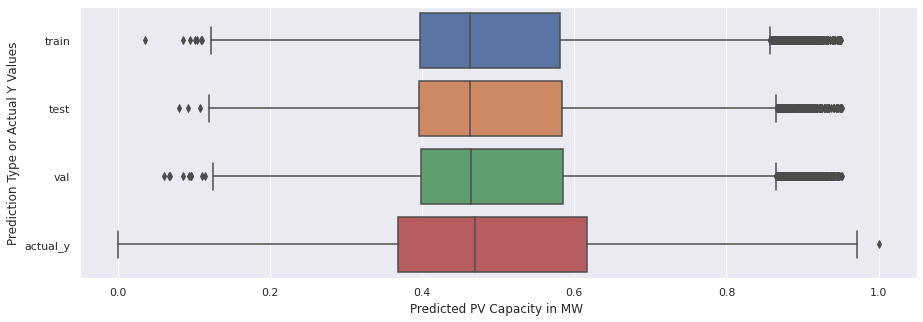

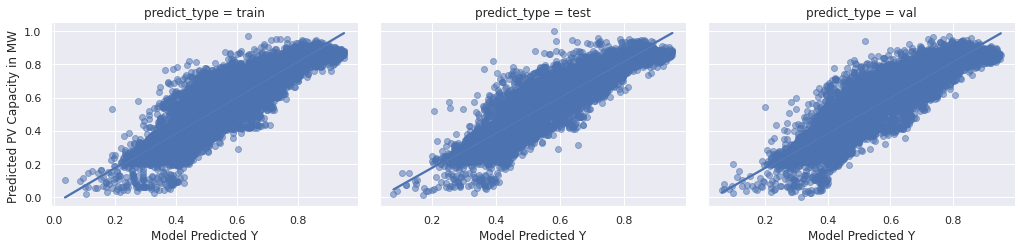

In [342]:
smodel1_7 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(250, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),    
        tf.keras.layers.Dense(150, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),   
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dense(1)
    ])
smodel1_7.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

shistory1_7 = smodel1_7.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_7,shistory1_7,'Solar Model 7 - Multilayer DNN with Batch Normalization and Higher Dropout and Lower LR History ','SModel1_7','solar','solar_model7')

## DNN Model 8 - Multilayer Model with Dropout

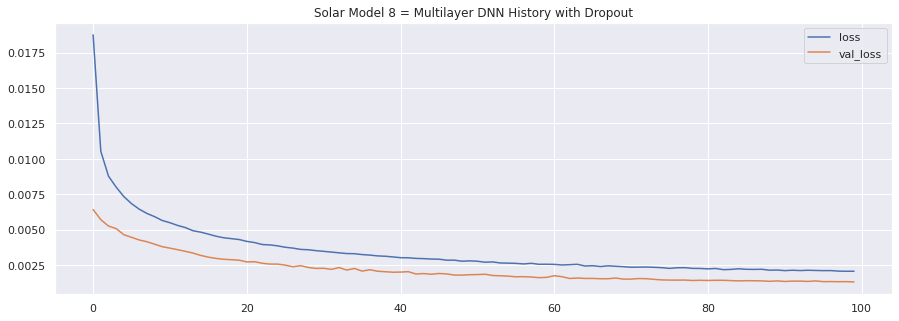

617/617 [==============================] - 1s 2ms/step
SModel1_8 train outcome has 0.00127 MSE and the predicted data has 97.97& correlation at 0.0 p-level with the actual data.
SModel1_8 test outcome has 0.00137 MSE and the predicted data has 97.85& correlation at 0.0 p-level with the actual data.
SModel1_8 val outcome has 0.00129 MSE and the predicted data has 97.92& correlation at 0.0 p-level with the actual data.


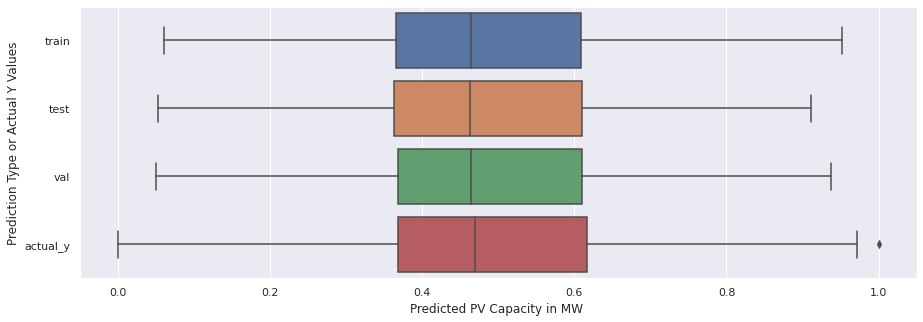

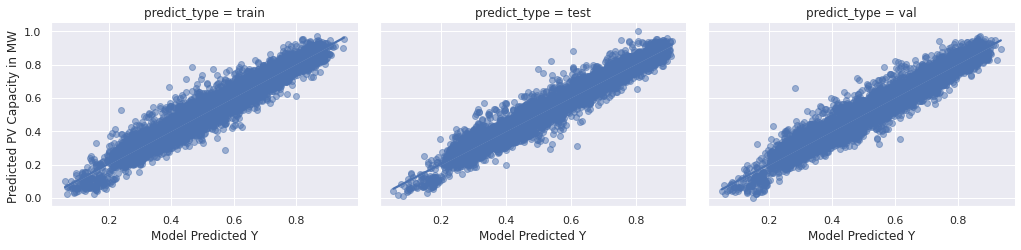

In [381]:
smodel1_8 = tf.keras.models.Sequential([
         tf.keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(200, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(100, activation="relu"),
         tf.keras.layers.Dropout(0.1),
         tf.keras.layers.Dense(1)
     ])
smodel1_8.compile(loss="mean_squared_error", optimizer="sgd")

shistory1_8 = smodel1_8.fit(X_train, y_train, epochs=EPOCHS, callbacks=[early_stopping_cb],
         validation_data=(X_val, y_val),verbose=False)
get_compiled_results(smodel1_8,shistory1_8,'Solar Model 8 = Multilayer DNN History with Dropout','SModel1_8','solar','solar_model8')

# Select Solar Model

In [382]:
solar_models = [smodel1_1,smodel1_2,smodel1_3,smodel1_4,smodel1_5,smodel1_6,smodel1_7,smodel1_8]
solar_histories = [history1_1,shistory1_2,shistory1_3,shistory1_4,shistory1_5,shistory1_6,shistory1_7,shistory1_8]
solar_results = []
for one,two in zip(solar_models,solar_histories):
  solar_results.append(get_model_results(one,two,'solar'))
index_names = []
for i in range(8):
  index_names.append(f'Solar Model {i+1}')
solar_r = pd.concat(solar_results)


617/617 [==============================] - 1s 2ms/step


In [383]:
solar_r_t = solar_r.copy().T
solar_r_t.columns = index_names
solar_results = solar_r_t.T
solar_results

,Train MSE,Train Corr,Test MSE,Test Corr,Validation MSE,Validation Corr,Train Loss Variance,Validation Loss Variance,Rate of Change in Train Loss,Rate of Change in Validation Loss
Solar Model 1,0.001386,97.73,0.001450,97.67,0.001383,97.73,2.304130e-06,1.020635e-06,-0.000127,-0.000043
Solar Model 2,0.005627,90.43,0.005651,90.58,0.005656,90.40,1.135652e-06,7.402042e-07,-0.000087,-0.000047
Solar Model 3,0.090604,-1.49,0.090239,0.12,0.090696,-0.64,8.994359e-09,9.342098e-09,-0.000004,-0.000003
Solar Model 4,0.001061,98.27,0.001131,98.20,0.001092,98.23,1.507801e-06,7.832122e-07,-0.000100,-0.000049
Solar Model 5,0.000996,98.40,0.001108,98.25,0.001075,98.28,6.086599e-05,2.231214e-05,-0.001268,-0.000301
Solar Model 6,0.001885,96.90,0.001994,96.77,0.001914,96.85,1.611952e-04,3.360176e-06,-0.001394,-0.000159
Solar Model 7,0.005089,91.64,0.005157,91.68,0.005097,91.59,4.457146e-03,1.902205e-05,-0.006613,-0.000207
Solar Model 8,0.001274,97.97,0.001369,97.85,0.001293,97.92,4.815560e-06,1.125949e-06,-0.000167,-0.000051


Chose Model 5 because the highest validation loss rate of change, although has high variance in validation loss. It also has the lowest Test and Validation MSE. 
However, looking at the graphs which is also seen from the Validation loss variance, it has one of the highest variance in validation loss, signalling a problem with the gradient. Model 4 has less of a validation variance while it has a similar MSE to Model 5, and also has similar levels of healthy correlation of train, test, validation predicted versus actual values.

# Run Model on the Rest of the Data

In [508]:
def get_model_results(bioclim_data,wind_or_solar,model,outcome_col_name):
  wind_x, wind_y, solar_x, solar_y, wind_df, solar_df = get_x_y(bioclim_data)
  scaler = MinMaxScaler()
  if wind_or_solar == 'solar':
    scaled_df = pd.DataFrame(scaler.fit_transform(solar_x.join(solar_y)))
    outcome_y = model.predict(scaled_df.iloc[:,:-1])
    reversed_result = pd.DataFrame(scaler.inverse_transform(scaled_df.iloc[:,:-1].join(pd.DataFrame(outcome_y).rename({0:outcome_col_name},axis=1))))
    to_map_result = solar_df.iloc[:,:13].dropna(axis=1).reset_index().join(reversed_result).rename({'index':'to_drop'},axis=1).drop('to_drop',axis=1)
    col_list = [i for i in solar_df.dropna(axis=1).columns]
    col_list.append('PV Capacity Factor')
    to_map_result.columns = col_list
  else:
    scaled_df = pd.DataFrame(scaler.fit_transform(wind_x.join(wind_y)))
    outcome_y = model.predict(scaled_df.iloc[:,:-1])
    reversed_result = pd.DataFrame(scaler.inverse_transform(scaled_df.iloc[:,:-1].join(pd.DataFrame(outcome_y).rename({0:outcome_col_name},axis=1))))
    to_map_result = wind_df.iloc[:,:13].dropna(axis=1).reset_index().join(reversed_result).rename({'index':'to_drop'},axis=1).drop('to_drop',axis=1)
    col_list = [i for i in wind_df.dropna(axis=1).columns]
    col_list.append('Wind Capacity Factor')
    to_map_result.columns = col_list
  return to_map_result


In [509]:
df_names = ['ssp2_10_40','ssp2_41_70','ssp5_10_40','ssp5_41_70']
outcome_dfs = [ssp2_10_40,ssp2_41_70,ssp5_10_40,ssp5_41_70]
results = {}
for df_name,df in zip(df_names,outcome_dfs):
  results[df_name] = get_model_results(df,'solar',smodel1_4,f'{df_name}_outcome')
  results[df_name].to_csv(f'{df_name}_outcome.csv')

1711/1711 [==============================] - 3s 2ms/step


# Plot Results

In [527]:
def plot_density(df, y, radius, saveas, zoom, color_range):
    fig = px.density_mapbox(df, lat='latitude',lon='longitude',z=y,radius=3.8,zoom=zoom,color_continuous_scale='thermal',range_color=color_range)
    fig.update_layout(
            geo_scope='usa',
        )
    fig.update_layout(mapbox_style="white-bg",
                      mapbox=dict(center=go.layout.mapbox.Center(lat=38.8283, lon=-95.5795)))

    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.write_image(f'{saveas}_map.png', width=950, height=450)

    # fig.show()
#Used this locally because kaleido wouldn't work
for file in os.listdir(os.getcwd()+'/outcomes'):
    df = pd.read_csv(os.getcwd()+'/outcomes/'+file)
    plot_density(df,'PV Capacity Factor', 3.8, f'{file}_map',3.2, [0.1,0.3])

In [529]:
get_model_results(normal,'solar',smodel1_4,f'normal_outcome').to_csv(f'normal_model_outcome.csv')

1644/1644 [==============================] - 4s 2ms/step


In [531]:
normal.iloc[:,:14]

,latitude,longitude,area_sq_km,capacity_m,generation,capacity_f,wind_speed,distance_t,pv_capacit,pv_global_,pv_capac_1,pv_,pv_distanc,dd_0
0,38.668999,-90.156998,2.397600,7.192800,22868.155090,0.362935,6.724702,0.041277,NaN,NaN,NaN,NaN,NaN,193.0
1,36.148998,-95.921997,2.243700,6.731100,25669.580330,0.435340,7.571970,0.058771,NaN,NaN,NaN,NaN,NaN,83.0
2,38.674999,-90.297997,0.513591,1.540772,4992.873453,0.369920,6.806532,0.047454,NaN,NaN,NaN,NaN,NaN,191.0
3,45.380001,-92.155998,41.990400,125.971200,476072.697300,0.431418,7.490105,0.055366,NaN,NaN,NaN,NaN,NaN,1018.0
4,47.574001,-95.418999,38.944800,116.834400,484907.334100,0.473788,8.033649,0.076005,NaN,NaN,NaN,NaN,NaN,1336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110225,25.982000,-97.349000,NaN,NaN,NaN,NaN,NaN,NaN,0.206913,5.196184,965.520000,30.172500,22.586464,3.0
110226,25.983000,-97.231000,NaN,NaN,NaN,NaN,NaN,NaN,0.205765,5.174338,238.679140,7.458723,9.374740,3.0
110227,25.877000,-97.583000,NaN,NaN,NaN,NaN,NaN,NaN,0.208000,5.208001,25.093151,0.784161,4.844146,3.0
110228,25.879000,-97.465000,NaN,NaN,NaN,NaN,NaN,NaN,0.207652,5.203368,330.091200,10.315350,5.204726,2.0
